<a href="https://colab.research.google.com/github/KFUPMeer/capstoneteam24/blob/main/Copy_of_how_to_estimate_vehicle_speed_with_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Estimate Vehicle Speed with Computer Vision

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/uWP6UjDeZvY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/supervision/tree/develop/examples/speed_estimation)

## Accompanying Materials

We recommend that you follow along in this notebook while watching the YouTube [tutorial](https://youtu.be/uWP6UjDeZvY) on how to estimate vehicle speed with computer vision. You can also find the code below in Python script form as one of the [supervision/examples](https://github.com/roboflow/supervision/tree/develop/examples).

[![YouTube Video](https://github.com/SkalskiP/SkalskiP/assets/26109316/61a444c8-b135-48ce-b979-2a5ab47c5a91)](https://youtu.be/uWP6UjDeZvY)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install
- Imports
- Download Data
- Configuration
- Source and Target ROIs
- Transform Perspective
- Process Video

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat Feb 24 12:41:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install

In [3]:
!pip install -q supervision ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 8.1 MB/s eta 0:00:00


In [16]:
pip install supervision[assets]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.2
    Uninstalling tqdm-4.66.2:
      Successfully uninstalled tqdm-4.66.2


## Imports

In [4]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque


## Download Data

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [65]:
download_assets(VideoAssets.VEHICLES)

vehicles.mp4 asset download complete. 



'vehicles.mp4'

## Configuration

In [68]:
SOURCE_VIDEO_PATH = "vehicles.mp4"
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

## Source and Target ROIs

![Source and Target ROIs](https://storage.googleapis.com/com-roboflow-marketing/notebooks/speed-estimation-perspective-1.png)

https://roboflow.github.io/polygonzone/

In [88]:
SOURCE = np.array([
[1232, 795],[2300, 787],[3360, 1271],[544, 1283]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 200

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [89]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

<ipython-input-90-077bb0d4283b>:2: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)


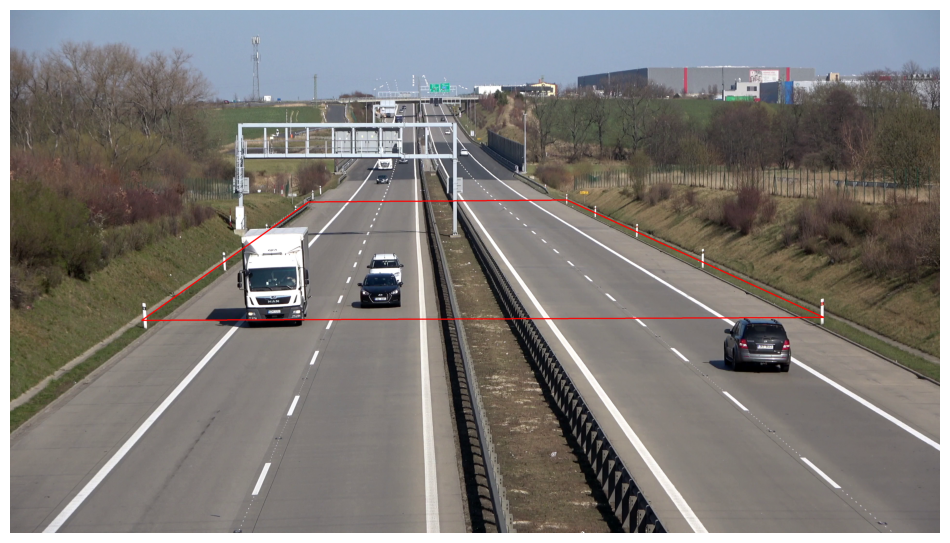

In [90]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

## Transform Perspective

In [91]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [92]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Process Video

**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

In [93]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_dynamic_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_dynamic_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
# ... (previous code remains unchanged)
previous_speeds = defaultdict(lambda: 0)

# ... (rest of the code)

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        car_counter = 0 # Initialize car counter for this frame

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Count the cars
        car_counter += len(detections)
        print(f"Number of cars in this frame: {car_counter}")

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels



        labels = []
        # Initialize a dictionary to store previous speeds for each tracker

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                label = f"#{tracker_id}"
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                current_speed = (distance / time) * 3.6
                # calculate the change in speed (delta_speed)
                previous_speed = previous_speeds[tracker_id]
                delta_speed = current_speed - previous_speed

                # update the previous speed for the next frame
                previous_speeds[tracker_id] = current_speed

                # calculate acceleration (assuming the time interval is 1 frame)
                acceleration = delta_speed * video_info.fps / 3.6  # converting km/h per frame to m/s^2

                # Combine speed and acceleration into a single label
                label = f"#{tracker_id} {int(current_speed)} km/h {acceleration:.2f} m/s^2"
            labels.append(label)

        if len(labels) != len(detections):
            raise ValueError("The number of labels is not equal to the number of detections.")

        # Print the number of cars detected in this frame
        print(f"Number of cars in this frame: {len(detections)}")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

  0%|          | 1/538 [00:01<14:42,  1.64s/it]

Number of cars in this frame: 7
Number of cars in this frame: 2


  0%|          | 2/538 [00:01<07:21,  1.21it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


  1%|          | 3/538 [00:02<04:56,  1.81it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


  1%|          | 4/538 [00:02<03:48,  2.34it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


  1%|          | 5/538 [00:02<03:11,  2.79it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


  1%|          | 6/538 [00:02<02:48,  3.16it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


  1%|▏         | 7/538 [00:03<02:32,  3.48it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  1%|▏         | 8/538 [00:03<02:22,  3.73it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  2%|▏         | 9/538 [00:03<02:15,  3.90it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  2%|▏         | 10/538 [00:03<02:11,  4.03it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  2%|▏         | 11/538 [00:03<02:07,  4.13it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  2%|▏         | 12/538 [00:04<02:11,  3.99it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  2%|▏         | 13/538 [00:04<02:13,  3.93it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  3%|▎         | 14/538 [00:04<02:18,  3.78it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  3%|▎         | 15/538 [00:05<02:20,  3.73it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  3%|▎         | 16/538 [00:05<02:17,  3.79it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  3%|▎         | 17/538 [00:05<02:22,  3.65it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  3%|▎         | 18/538 [00:05<02:23,  3.63it/s]

Number of cars in this frame: 7
Number of cars in this frame: 0


  4%|▎         | 19/538 [00:06<02:24,  3.58it/s]

Number of cars in this frame: 8
Number of cars in this frame: 0


  4%|▎         | 20/538 [00:06<02:17,  3.78it/s]

Number of cars in this frame: 8
Number of cars in this frame: 0


  4%|▍         | 21/538 [00:06<02:11,  3.94it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  4%|▍         | 22/538 [00:06<02:06,  4.07it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  4%|▍         | 23/538 [00:07<02:04,  4.13it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  4%|▍         | 24/538 [00:07<02:02,  4.21it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  5%|▍         | 25/538 [00:07<02:00,  4.26it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  5%|▍         | 26/538 [00:07<02:01,  4.21it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  5%|▌         | 27/538 [00:08<02:00,  4.25it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  5%|▌         | 28/538 [00:08<01:59,  4.28it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  5%|▌         | 29/538 [00:08<01:58,  4.29it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  6%|▌         | 30/538 [00:08<01:57,  4.33it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


  6%|▌         | 31/538 [00:08<01:57,  4.32it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  6%|▌         | 32/538 [00:09<01:57,  4.32it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  6%|▌         | 33/538 [00:09<01:56,  4.33it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  6%|▋         | 34/538 [00:09<01:56,  4.34it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  7%|▋         | 35/538 [00:09<01:56,  4.32it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  7%|▋         | 36/538 [00:10<01:57,  4.29it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  7%|▋         | 37/538 [00:10<01:55,  4.33it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  7%|▋         | 38/538 [00:10<01:56,  4.28it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  7%|▋         | 39/538 [00:10<01:57,  4.25it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  7%|▋         | 40/538 [00:11<01:55,  4.31it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  8%|▊         | 41/538 [00:11<01:55,  4.29it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  8%|▊         | 42/538 [00:11<01:54,  4.32it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  8%|▊         | 43/538 [00:11<01:54,  4.32it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  8%|▊         | 44/538 [00:11<01:53,  4.36it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  8%|▊         | 45/538 [00:12<01:54,  4.30it/s]

Number of cars in this frame: 9
Number of cars in this frame: 1


  9%|▊         | 46/538 [00:12<01:53,  4.34it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  9%|▊         | 47/538 [00:12<01:53,  4.33it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  9%|▉         | 48/538 [00:12<01:53,  4.31it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  9%|▉         | 49/538 [00:13<01:53,  4.32it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  9%|▉         | 50/538 [00:13<01:53,  4.29it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


  9%|▉         | 51/538 [00:13<01:53,  4.30it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


 10%|▉         | 52/538 [00:13<01:52,  4.32it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


 10%|▉         | 53/538 [00:14<01:51,  4.36it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


 10%|█         | 54/538 [00:14<01:51,  4.35it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


 10%|█         | 55/538 [00:14<01:51,  4.34it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


 10%|█         | 56/538 [00:14<01:52,  4.30it/s]

Number of cars in this frame: 8
Number of cars in this frame: 1


 11%|█         | 57/538 [00:14<01:52,  4.26it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 11%|█         | 58/538 [00:15<01:51,  4.29it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 11%|█         | 59/538 [00:15<01:52,  4.26it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 11%|█         | 60/538 [00:15<01:53,  4.22it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 11%|█▏        | 61/538 [00:15<01:52,  4.25it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 12%|█▏        | 62/538 [00:16<01:52,  4.23it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 12%|█▏        | 63/538 [00:16<01:56,  4.07it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 12%|█▏        | 64/538 [00:16<01:58,  4.00it/s]

Number of cars in this frame: 7
Number of cars in this frame: 1


 12%|█▏        | 65/538 [00:17<02:05,  3.78it/s]

Number of cars in this frame: 8
Number of cars in this frame: 2


 12%|█▏        | 66/538 [00:17<02:06,  3.73it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 12%|█▏        | 67/538 [00:17<02:09,  3.63it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 13%|█▎        | 68/538 [00:17<02:07,  3.68it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 13%|█▎        | 69/538 [00:18<02:07,  3.68it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 13%|█▎        | 70/538 [00:18<02:06,  3.69it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 13%|█▎        | 71/538 [00:18<02:05,  3.72it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 13%|█▎        | 72/538 [00:18<01:59,  3.90it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 14%|█▎        | 73/538 [00:19<01:56,  3.99it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 14%|█▍        | 74/538 [00:19<01:54,  4.04it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 14%|█▍        | 75/538 [00:19<01:52,  4.11it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 14%|█▍        | 76/538 [00:19<01:51,  4.14it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 14%|█▍        | 77/538 [00:20<01:49,  4.20it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 14%|█▍        | 78/538 [00:20<01:49,  4.20it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 15%|█▍        | 79/538 [00:20<01:47,  4.27it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 15%|█▍        | 80/538 [00:20<01:46,  4.31it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 15%|█▌        | 81/538 [00:20<01:45,  4.32it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 15%|█▌        | 82/538 [00:21<01:46,  4.28it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 15%|█▌        | 83/538 [00:21<01:46,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 16%|█▌        | 84/538 [00:21<01:46,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 16%|█▌        | 85/538 [00:21<01:45,  4.28it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 16%|█▌        | 86/538 [00:22<01:46,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 16%|█▌        | 87/538 [00:22<01:47,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 16%|█▋        | 88/538 [00:22<01:45,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 17%|█▋        | 89/538 [00:22<01:45,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 17%|█▋        | 90/538 [00:23<01:44,  4.28it/s]

Number of cars in this frame: 6
Number of cars in this frame: 3


 17%|█▋        | 91/538 [00:23<01:43,  4.30it/s]

Number of cars in this frame: 6
Number of cars in this frame: 3


 17%|█▋        | 92/538 [00:23<01:43,  4.31it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 17%|█▋        | 93/538 [00:23<01:42,  4.34it/s]

Number of cars in this frame: 6
Number of cars in this frame: 3


 17%|█▋        | 94/538 [00:24<01:43,  4.30it/s]

Number of cars in this frame: 6
Number of cars in this frame: 3


 18%|█▊        | 95/538 [00:24<01:43,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 18%|█▊        | 96/538 [00:24<01:45,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 18%|█▊        | 97/538 [00:24<01:43,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 18%|█▊        | 98/538 [00:24<01:44,  4.19it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3
Number of cars in this frame: 5
Number of cars in this frame: 3


 19%|█▊        | 100/538 [00:25<02:07,  3.43it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 19%|█▉        | 101/538 [00:25<01:59,  3.66it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3
Number of cars in this frame: 5
Number of cars in this frame: 3


 19%|█▉        | 103/538 [00:26<02:07,  3.41it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 19%|█▉        | 104/538 [00:26<01:59,  3.64it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3
Number of cars in this frame: 5
Number of cars in this frame: 3


 20%|█▉        | 106/538 [00:27<02:04,  3.47it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 20%|█▉        | 107/538 [00:27<01:57,  3.68it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 20%|██        | 108/538 [00:27<01:51,  3.84it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 20%|██        | 109/538 [00:28<01:48,  3.95it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 20%|██        | 110/538 [00:28<01:47,  3.96it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 21%|██        | 111/538 [00:28<01:49,  3.88it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 21%|██        | 112/538 [00:28<01:51,  3.81it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 21%|██        | 113/538 [00:29<01:51,  3.80it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 21%|██        | 114/538 [00:29<01:53,  3.73it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 21%|██▏       | 115/538 [00:29<01:54,  3.68it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 22%|██▏       | 116/538 [00:30<01:59,  3.53it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 22%|██▏       | 117/538 [00:30<01:58,  3.54it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 22%|██▏       | 118/538 [00:30<01:57,  3.58it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 22%|██▏       | 119/538 [00:30<01:55,  3.62it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 22%|██▏       | 120/538 [00:31<01:49,  3.81it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 22%|██▏       | 121/538 [00:31<01:46,  3.92it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 23%|██▎       | 122/538 [00:31<01:45,  3.94it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 23%|██▎       | 123/538 [00:31<01:42,  4.05it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 23%|██▎       | 124/538 [00:32<01:40,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 23%|██▎       | 125/538 [00:32<01:39,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 23%|██▎       | 126/538 [00:32<01:39,  4.15it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 24%|██▎       | 127/538 [00:32<01:37,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 24%|██▍       | 128/538 [00:33<01:37,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 24%|██▍       | 129/538 [00:33<01:36,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 24%|██▍       | 130/538 [00:33<01:36,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 24%|██▍       | 131/538 [00:33<01:37,  4.19it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 25%|██▍       | 132/538 [00:33<01:36,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 25%|██▍       | 133/538 [00:34<01:35,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 25%|██▍       | 134/538 [00:34<01:36,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 25%|██▌       | 135/538 [00:34<01:35,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 25%|██▌       | 136/538 [00:34<01:35,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 25%|██▌       | 137/538 [00:35<01:34,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 26%|██▌       | 138/538 [00:35<01:34,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 26%|██▌       | 139/538 [00:35<01:33,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 26%|██▌       | 140/538 [00:35<01:32,  4.28it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 26%|██▌       | 141/538 [00:36<01:32,  4.29it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 26%|██▋       | 142/538 [00:36<01:32,  4.30it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 27%|██▋       | 143/538 [00:36<01:31,  4.30it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 27%|██▋       | 144/538 [00:36<01:31,  4.30it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 27%|██▋       | 145/538 [00:37<01:32,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 27%|██▋       | 146/538 [00:37<01:32,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 27%|██▋       | 147/538 [00:37<01:32,  4.24it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 28%|██▊       | 148/538 [00:37<01:31,  4.28it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 28%|██▊       | 149/538 [00:37<01:30,  4.29it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 28%|██▊       | 150/538 [00:38<01:30,  4.30it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 28%|██▊       | 151/538 [00:38<01:30,  4.27it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 28%|██▊       | 152/538 [00:38<01:31,  4.23it/s]

Number of cars in this frame: 6
Number of cars in this frame: 3


 28%|██▊       | 153/538 [00:38<01:31,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 29%|██▊       | 154/538 [00:39<01:30,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 29%|██▉       | 155/538 [00:39<01:29,  4.27it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 29%|██▉       | 156/538 [00:39<01:29,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 29%|██▉       | 157/538 [00:39<01:29,  4.24it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 29%|██▉       | 158/538 [00:40<01:30,  4.20it/s]

Number of cars in this frame: 6
Number of cars in this frame: 3


 30%|██▉       | 159/538 [00:40<01:29,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 30%|██▉       | 160/538 [00:40<01:29,  4.24it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 30%|██▉       | 161/538 [00:40<01:29,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 30%|███       | 162/538 [00:41<01:32,  4.06it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 30%|███       | 163/538 [00:41<01:37,  3.86it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 30%|███       | 164/538 [00:41<01:36,  3.86it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 31%|███       | 165/538 [00:41<01:40,  3.70it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 31%|███       | 166/538 [00:42<01:42,  3.63it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 31%|███       | 167/538 [00:42<01:41,  3.64it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 31%|███       | 168/538 [00:42<01:42,  3.62it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 31%|███▏      | 169/538 [00:43<01:43,  3.55it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 32%|███▏      | 170/538 [00:43<01:42,  3.61it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 32%|███▏      | 171/538 [00:43<01:37,  3.77it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 32%|███▏      | 172/538 [00:43<01:33,  3.93it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 32%|███▏      | 173/538 [00:44<01:31,  4.01it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 32%|███▏      | 174/538 [00:44<01:29,  4.08it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 33%|███▎      | 175/538 [00:44<01:28,  4.11it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 33%|███▎      | 176/538 [00:44<01:27,  4.15it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 33%|███▎      | 177/538 [00:44<01:27,  4.14it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 33%|███▎      | 178/538 [00:45<01:26,  4.15it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 33%|███▎      | 179/538 [00:45<01:28,  4.08it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 33%|███▎      | 180/538 [00:45<01:27,  4.11it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 34%|███▎      | 181/538 [00:45<01:27,  4.08it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 34%|███▍      | 182/538 [00:46<01:27,  4.06it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 34%|███▍      | 183/538 [00:46<01:26,  4.08it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 34%|███▍      | 184/538 [00:46<01:25,  4.13it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 34%|███▍      | 185/538 [00:46<01:25,  4.11it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 35%|███▍      | 186/538 [00:47<01:25,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 35%|███▍      | 187/538 [00:47<01:24,  4.14it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 35%|███▍      | 188/538 [00:47<01:23,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 35%|███▌      | 189/538 [00:47<01:23,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 35%|███▌      | 190/538 [00:48<01:23,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 36%|███▌      | 191/538 [00:48<01:22,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 36%|███▌      | 192/538 [00:48<01:22,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 36%|███▌      | 193/538 [00:48<01:22,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 36%|███▌      | 194/538 [00:49<01:22,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 36%|███▌      | 195/538 [00:49<01:21,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 36%|███▋      | 196/538 [00:49<01:21,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 37%|███▋      | 197/538 [00:49<01:20,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 37%|███▋      | 198/538 [00:50<01:20,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 37%|███▋      | 199/538 [00:50<01:20,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 37%|███▋      | 200/538 [00:50<01:20,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 37%|███▋      | 201/538 [00:50<01:20,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 38%|███▊      | 202/538 [00:50<01:20,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 4


 38%|███▊      | 203/538 [00:51<01:20,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 4


 38%|███▊      | 204/538 [00:51<01:19,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 4


 38%|███▊      | 205/538 [00:51<01:19,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 4


 38%|███▊      | 206/538 [00:51<01:19,  4.15it/s]

Number of cars in this frame: 5
Number of cars in this frame: 4


 38%|███▊      | 207/538 [00:52<01:19,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 39%|███▊      | 208/538 [00:52<01:18,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 39%|███▉      | 209/538 [00:52<01:17,  4.24it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 39%|███▉      | 210/538 [00:52<01:17,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 39%|███▉      | 211/538 [00:53<01:19,  4.11it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 39%|███▉      | 212/538 [00:53<01:24,  3.88it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 40%|███▉      | 213/538 [00:53<01:25,  3.80it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 40%|███▉      | 214/538 [00:53<01:27,  3.69it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 40%|███▉      | 215/538 [00:54<01:28,  3.66it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 40%|████      | 216/538 [00:54<01:28,  3.63it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 40%|████      | 217/538 [00:54<01:28,  3.61it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 41%|████      | 218/538 [00:55<01:31,  3.51it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 41%|████      | 219/538 [00:55<01:32,  3.44it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 41%|████      | 220/538 [00:55<01:27,  3.63it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 41%|████      | 221/538 [00:55<01:23,  3.79it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 41%|████▏     | 222/538 [00:56<01:21,  3.87it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 41%|████▏     | 223/538 [00:56<01:18,  4.00it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 42%|████▏     | 224/538 [00:56<01:17,  4.07it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 42%|████▏     | 225/538 [00:56<01:15,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 42%|████▏     | 226/538 [00:57<01:15,  4.14it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 42%|████▏     | 227/538 [00:57<01:14,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 3


 42%|████▏     | 228/538 [00:57<01:14,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 43%|████▎     | 229/538 [00:57<01:13,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 43%|████▎     | 230/538 [00:58<01:14,  4.14it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 43%|████▎     | 231/538 [00:58<01:14,  4.10it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 43%|████▎     | 232/538 [00:58<01:14,  4.13it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 43%|████▎     | 233/538 [00:58<01:13,  4.13it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 43%|████▎     | 234/538 [00:59<01:13,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 44%|████▎     | 235/538 [00:59<01:13,  4.15it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 44%|████▍     | 236/538 [00:59<01:13,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 44%|████▍     | 237/538 [00:59<01:13,  4.09it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 44%|████▍     | 238/538 [01:00<01:13,  4.09it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 44%|████▍     | 239/538 [01:00<01:14,  4.00it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 45%|████▍     | 240/538 [01:00<01:13,  4.04it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 45%|████▍     | 241/538 [01:00<01:12,  4.07it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 45%|████▍     | 242/538 [01:01<01:13,  4.05it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 45%|████▌     | 243/538 [01:01<01:12,  4.07it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 45%|████▌     | 244/538 [01:01<01:11,  4.13it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 46%|████▌     | 245/538 [01:01<01:11,  4.11it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 46%|████▌     | 246/538 [01:01<01:10,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 46%|████▌     | 247/538 [01:02<01:09,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 46%|████▌     | 248/538 [01:02<01:09,  4.15it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 46%|████▋     | 249/538 [01:02<01:09,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 46%|████▋     | 250/538 [01:02<01:08,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 47%|████▋     | 251/538 [01:03<01:09,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 47%|████▋     | 252/538 [01:03<01:09,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 47%|████▋     | 253/538 [01:03<01:09,  4.09it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 47%|████▋     | 254/538 [01:03<01:09,  4.11it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 47%|████▋     | 255/538 [01:04<01:08,  4.14it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 48%|████▊     | 256/538 [01:04<01:07,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 48%|████▊     | 257/538 [01:04<01:06,  4.23it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 48%|████▊     | 258/538 [01:04<01:07,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 48%|████▊     | 259/538 [01:05<01:07,  4.14it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 48%|████▊     | 260/538 [01:05<01:06,  4.17it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 49%|████▊     | 261/538 [01:05<01:09,  3.98it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 49%|████▊     | 262/538 [01:05<01:14,  3.73it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 49%|████▉     | 263/538 [01:06<01:14,  3.68it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 49%|████▉     | 264/538 [01:06<01:18,  3.47it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 49%|████▉     | 265/538 [01:06<01:17,  3.52it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 49%|████▉     | 266/538 [01:07<01:19,  3.43it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 50%|████▉     | 267/538 [01:07<01:19,  3.41it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 50%|████▉     | 268/538 [01:07<01:17,  3.46it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 50%|█████     | 269/538 [01:07<01:14,  3.63it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 50%|█████     | 270/538 [01:08<01:10,  3.80it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 50%|█████     | 271/538 [01:08<01:08,  3.91it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 51%|█████     | 272/538 [01:08<01:07,  3.92it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 51%|█████     | 273/538 [01:08<01:05,  4.03it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 51%|█████     | 274/538 [01:09<01:04,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 51%|█████     | 275/538 [01:09<01:03,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 51%|█████▏    | 276/538 [01:09<01:03,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 51%|█████▏    | 277/538 [01:09<01:02,  4.15it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 52%|█████▏    | 278/538 [01:10<01:03,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 52%|█████▏    | 279/538 [01:10<01:04,  4.03it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 52%|█████▏    | 280/538 [01:10<01:03,  4.05it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 52%|█████▏    | 281/538 [01:10<01:02,  4.12it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 52%|█████▏    | 282/538 [01:11<01:01,  4.15it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 53%|█████▎    | 283/538 [01:11<01:02,  4.09it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 53%|█████▎    | 284/538 [01:11<01:01,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 53%|█████▎    | 285/538 [01:11<01:01,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 53%|█████▎    | 286/538 [01:12<01:01,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 53%|█████▎    | 287/538 [01:12<01:01,  4.10it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 54%|█████▎    | 288/538 [01:12<01:01,  4.07it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 54%|█████▎    | 289/538 [01:12<01:01,  4.07it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 54%|█████▍    | 290/538 [01:13<01:00,  4.07it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 54%|█████▍    | 291/538 [01:13<01:01,  4.04it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 54%|█████▍    | 292/538 [01:13<01:00,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 54%|█████▍    | 293/538 [01:13<00:59,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 55%|█████▍    | 294/538 [01:14<00:59,  4.09it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 55%|█████▍    | 295/538 [01:14<00:59,  4.10it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 55%|█████▌    | 296/538 [01:14<00:59,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 55%|█████▌    | 297/538 [01:14<00:59,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 55%|█████▌    | 298/538 [01:14<00:58,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 56%|█████▌    | 299/538 [01:15<00:57,  4.18it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 56%|█████▌    | 300/538 [01:15<00:57,  4.17it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 56%|█████▌    | 301/538 [01:15<00:56,  4.22it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 56%|█████▌    | 302/538 [01:15<00:56,  4.17it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 56%|█████▋    | 303/538 [01:16<00:56,  4.15it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 57%|█████▋    | 304/538 [01:16<00:56,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 57%|█████▋    | 305/538 [01:16<00:56,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 57%|█████▋    | 306/538 [01:16<00:55,  4.14it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 57%|█████▋    | 307/538 [01:17<00:55,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 57%|█████▋    | 308/538 [01:17<00:54,  4.21it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 57%|█████▋    | 309/538 [01:17<00:53,  4.26it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 58%|█████▊    | 310/538 [01:17<00:54,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 58%|█████▊    | 311/538 [01:18<00:58,  3.91it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 58%|█████▊    | 312/538 [01:18<00:59,  3.81it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 58%|█████▊    | 313/538 [01:18<01:01,  3.64it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 58%|█████▊    | 314/538 [01:18<01:01,  3.64it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 59%|█████▊    | 315/538 [01:19<01:01,  3.65it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 59%|█████▊    | 316/538 [01:19<01:00,  3.66it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 59%|█████▉    | 317/538 [01:19<01:01,  3.58it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 59%|█████▉    | 318/538 [01:20<01:01,  3.56it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 59%|█████▉    | 319/538 [01:20<00:58,  3.73it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 59%|█████▉    | 320/538 [01:20<00:57,  3.81it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 60%|█████▉    | 321/538 [01:20<00:54,  3.96it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 60%|█████▉    | 322/538 [01:21<00:54,  4.00it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 60%|██████    | 323/538 [01:21<00:52,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 60%|██████    | 324/538 [01:21<00:52,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 60%|██████    | 325/538 [01:21<00:51,  4.13it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 61%|██████    | 326/538 [01:22<00:51,  4.15it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 61%|██████    | 327/538 [01:22<00:50,  4.18it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 61%|██████    | 328/538 [01:22<00:49,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 61%|██████    | 329/538 [01:22<00:49,  4.26it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 61%|██████▏   | 330/538 [01:22<00:48,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 62%|██████▏   | 331/538 [01:23<00:48,  4.27it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 62%|██████▏   | 332/538 [01:23<00:47,  4.30it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 62%|██████▏   | 333/538 [01:23<00:47,  4.31it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 62%|██████▏   | 334/538 [01:23<00:47,  4.29it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 62%|██████▏   | 335/538 [01:24<00:48,  4.20it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 62%|██████▏   | 336/538 [01:24<00:48,  4.20it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 63%|██████▎   | 337/538 [01:24<00:47,  4.25it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 63%|██████▎   | 338/538 [01:24<00:47,  4.22it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 63%|██████▎   | 339/538 [01:25<00:46,  4.28it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 63%|██████▎   | 340/538 [01:25<00:45,  4.31it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 63%|██████▎   | 341/538 [01:25<00:46,  4.28it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 64%|██████▎   | 342/538 [01:25<00:45,  4.29it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 64%|██████▍   | 343/538 [01:26<00:46,  4.22it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 64%|██████▍   | 344/538 [01:26<00:45,  4.24it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 64%|██████▍   | 345/538 [01:26<00:45,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 64%|██████▍   | 346/538 [01:26<00:45,  4.25it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 64%|██████▍   | 347/538 [01:26<00:44,  4.28it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 65%|██████▍   | 348/538 [01:27<00:45,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 65%|██████▍   | 349/538 [01:27<00:45,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 65%|██████▌   | 350/538 [01:27<00:45,  4.17it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 65%|██████▌   | 351/538 [01:27<00:44,  4.19it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 65%|██████▌   | 352/538 [01:28<00:44,  4.17it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 66%|██████▌   | 353/538 [01:28<00:43,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 66%|██████▌   | 354/538 [01:28<00:43,  4.22it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 66%|██████▌   | 355/538 [01:28<00:43,  4.23it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 66%|██████▌   | 356/538 [01:29<00:42,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 66%|██████▋   | 357/538 [01:29<00:42,  4.28it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 67%|██████▋   | 358/538 [01:29<00:41,  4.29it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 67%|██████▋   | 359/538 [01:29<00:42,  4.26it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 67%|██████▋   | 360/538 [01:30<00:41,  4.27it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 67%|██████▋   | 361/538 [01:30<00:43,  4.05it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 67%|██████▋   | 362/538 [01:30<00:46,  3.79it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 67%|██████▋   | 363/538 [01:30<00:48,  3.64it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 68%|██████▊   | 364/538 [01:31<00:48,  3.57it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 68%|██████▊   | 365/538 [01:31<00:49,  3.50it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 68%|██████▊   | 366/538 [01:31<00:49,  3.47it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 68%|██████▊   | 367/538 [01:32<00:50,  3.41it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 68%|██████▊   | 368/538 [01:32<00:50,  3.37it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 69%|██████▊   | 369/538 [01:32<00:46,  3.60it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 69%|██████▉   | 370/538 [01:32<00:44,  3.75it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 69%|██████▉   | 371/538 [01:33<00:42,  3.91it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 69%|██████▉   | 372/538 [01:33<00:42,  3.95it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 69%|██████▉   | 373/538 [01:33<00:41,  4.00it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 70%|██████▉   | 374/538 [01:33<00:40,  4.05it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 70%|██████▉   | 375/538 [01:34<00:39,  4.11it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 70%|██████▉   | 376/538 [01:34<00:38,  4.20it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 70%|███████   | 377/538 [01:34<00:38,  4.22it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 70%|███████   | 378/538 [01:34<00:37,  4.27it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 70%|███████   | 379/538 [01:35<00:37,  4.21it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 71%|███████   | 380/538 [01:35<00:37,  4.23it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 71%|███████   | 381/538 [01:35<00:37,  4.14it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 71%|███████   | 382/538 [01:35<00:37,  4.17it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 71%|███████   | 383/538 [01:35<00:37,  4.15it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 71%|███████▏  | 384/538 [01:36<00:36,  4.19it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 72%|███████▏  | 385/538 [01:36<00:36,  4.16it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 72%|███████▏  | 386/538 [01:36<00:36,  4.15it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 72%|███████▏  | 387/538 [01:36<00:36,  4.19it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 72%|███████▏  | 388/538 [01:37<00:35,  4.21it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 72%|███████▏  | 389/538 [01:37<00:35,  4.23it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 72%|███████▏  | 390/538 [01:37<00:34,  4.23it/s]

Number of cars in this frame: 8
Number of cars in this frame: 2


 73%|███████▎  | 391/538 [01:37<00:35,  4.18it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 73%|███████▎  | 392/538 [01:38<00:34,  4.18it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 73%|███████▎  | 393/538 [01:38<00:34,  4.18it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 73%|███████▎  | 394/538 [01:38<00:34,  4.14it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 73%|███████▎  | 395/538 [01:38<00:34,  4.15it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 74%|███████▎  | 396/538 [01:39<00:33,  4.18it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 74%|███████▍  | 397/538 [01:39<00:33,  4.23it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 74%|███████▍  | 398/538 [01:39<00:32,  4.25it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 74%|███████▍  | 399/538 [01:39<00:32,  4.22it/s]

Number of cars in this frame: 7
Number of cars in this frame: 2


 74%|███████▍  | 400/538 [01:40<00:32,  4.26it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 75%|███████▍  | 401/538 [01:40<00:32,  4.27it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 75%|███████▍  | 402/538 [01:40<00:31,  4.27it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 75%|███████▍  | 403/538 [01:40<00:31,  4.26it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 75%|███████▌  | 404/538 [01:40<00:31,  4.27it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 75%|███████▌  | 405/538 [01:41<00:31,  4.24it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 75%|███████▌  | 406/538 [01:41<00:31,  4.25it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 76%|███████▌  | 407/538 [01:41<00:31,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 76%|███████▌  | 408/538 [01:41<00:31,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 76%|███████▌  | 409/538 [01:42<00:30,  4.21it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 76%|███████▌  | 410/538 [01:42<00:30,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 76%|███████▋  | 411/538 [01:42<00:31,  4.00it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 77%|███████▋  | 412/538 [01:42<00:32,  3.88it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 77%|███████▋  | 413/538 [01:43<00:33,  3.78it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 77%|███████▋  | 414/538 [01:43<00:33,  3.74it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 77%|███████▋  | 415/538 [01:43<00:33,  3.63it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 77%|███████▋  | 416/538 [01:44<00:34,  3.52it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 78%|███████▊  | 417/538 [01:44<00:33,  3.56it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 78%|███████▊  | 418/538 [01:44<00:34,  3.50it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 78%|███████▊  | 419/538 [01:44<00:32,  3.65it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 78%|███████▊  | 420/538 [01:45<00:30,  3.81it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 78%|███████▊  | 421/538 [01:45<00:29,  3.92it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 78%|███████▊  | 422/538 [01:45<00:29,  3.95it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 79%|███████▊  | 423/538 [01:45<00:28,  4.00it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 79%|███████▉  | 424/538 [01:46<00:27,  4.10it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 79%|███████▉  | 425/538 [01:46<00:27,  4.13it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 79%|███████▉  | 426/538 [01:46<00:27,  4.11it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 79%|███████▉  | 427/538 [01:46<00:27,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 80%|███████▉  | 428/538 [01:47<00:26,  4.13it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 80%|███████▉  | 429/538 [01:47<00:26,  4.15it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 80%|███████▉  | 430/538 [01:47<00:25,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 80%|████████  | 431/538 [01:47<00:26,  4.03it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 80%|████████  | 432/538 [01:48<00:26,  4.05it/s]

Number of cars in this frame: 6
Number of cars in this frame: 2


 80%|████████  | 433/538 [01:48<00:25,  4.10it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 81%|████████  | 434/538 [01:48<00:25,  4.10it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 81%|████████  | 435/538 [01:48<00:25,  4.12it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 81%|████████  | 436/538 [01:49<00:24,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 81%|████████  | 437/538 [01:49<00:24,  4.15it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 81%|████████▏ | 438/538 [01:49<00:23,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 82%|████████▏ | 439/538 [01:49<00:23,  4.19it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 82%|████████▏ | 440/538 [01:49<00:23,  4.16it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 82%|████████▏ | 441/538 [01:50<00:23,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 82%|████████▏ | 442/538 [01:50<00:22,  4.20it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 82%|████████▏ | 443/538 [01:50<00:22,  4.22it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 83%|████████▎ | 444/538 [01:50<00:22,  4.21it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 83%|████████▎ | 445/538 [01:51<00:22,  4.21it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 83%|████████▎ | 446/538 [01:51<00:21,  4.18it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 83%|████████▎ | 447/538 [01:51<00:21,  4.19it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 83%|████████▎ | 448/538 [01:51<00:21,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 83%|████████▎ | 449/538 [01:52<00:21,  4.18it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 84%|████████▎ | 450/538 [01:52<00:20,  4.19it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 84%|████████▍ | 451/538 [01:52<00:20,  4.17it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 84%|████████▍ | 452/538 [01:52<00:20,  4.18it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 84%|████████▍ | 453/538 [01:53<00:20,  4.12it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 84%|████████▍ | 454/538 [01:53<00:20,  4.09it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 85%|████████▍ | 455/538 [01:53<00:20,  4.04it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 85%|████████▍ | 456/538 [01:53<00:20,  4.10it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 85%|████████▍ | 457/538 [01:54<00:20,  4.04it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 85%|████████▌ | 458/538 [01:54<00:19,  4.06it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 85%|████████▌ | 459/538 [01:54<00:19,  4.07it/s]

Number of cars in this frame: 3
Number of cars in this frame: 2


 86%|████████▌ | 460/538 [01:54<00:19,  4.08it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 86%|████████▌ | 461/538 [01:55<00:19,  3.93it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 86%|████████▌ | 462/538 [01:55<00:20,  3.79it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 86%|████████▌ | 463/538 [01:55<00:20,  3.64it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 86%|████████▌ | 464/538 [01:55<00:21,  3.51it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 86%|████████▋ | 465/538 [01:56<00:21,  3.43it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 87%|████████▋ | 466/538 [01:56<00:20,  3.45it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 87%|████████▋ | 467/538 [01:56<00:20,  3.44it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 87%|████████▋ | 468/538 [01:57<00:20,  3.45it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 87%|████████▋ | 469/538 [01:57<00:18,  3.63it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 87%|████████▋ | 470/538 [01:57<00:17,  3.79it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 88%|████████▊ | 471/538 [01:57<00:17,  3.90it/s]

Number of cars in this frame: 3
Number of cars in this frame: 2


 88%|████████▊ | 472/538 [01:58<00:16,  3.97it/s]

Number of cars in this frame: 3
Number of cars in this frame: 2


 88%|████████▊ | 473/538 [01:58<00:16,  4.01it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 88%|████████▊ | 474/538 [01:58<00:15,  4.06it/s]

Number of cars in this frame: 5
Number of cars in this frame: 2


 88%|████████▊ | 475/538 [01:58<00:15,  4.10it/s]

Number of cars in this frame: 4
Number of cars in this frame: 2


 88%|████████▊ | 476/538 [01:59<00:14,  4.14it/s]

Number of cars in this frame: 3
Number of cars in this frame: 2


 89%|████████▊ | 477/538 [01:59<00:14,  4.07it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 89%|████████▉ | 478/538 [01:59<00:14,  4.10it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 89%|████████▉ | 479/538 [01:59<00:14,  4.18it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 89%|████████▉ | 480/538 [02:00<00:13,  4.22it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 89%|████████▉ | 481/538 [02:00<00:13,  4.23it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 90%|████████▉ | 482/538 [02:00<00:13,  4.14it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 90%|████████▉ | 483/538 [02:00<00:13,  4.16it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 90%|████████▉ | 484/538 [02:00<00:12,  4.22it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 90%|█████████ | 485/538 [02:01<00:12,  4.25it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 90%|█████████ | 486/538 [02:01<00:12,  4.25it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 91%|█████████ | 487/538 [02:01<00:11,  4.25it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 91%|█████████ | 488/538 [02:01<00:12,  4.15it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 91%|█████████ | 489/538 [02:02<00:11,  4.18it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 91%|█████████ | 490/538 [02:02<00:11,  4.11it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 91%|█████████▏| 491/538 [02:02<00:11,  4.11it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 91%|█████████▏| 492/538 [02:02<00:11,  4.09it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 92%|█████████▏| 493/538 [02:03<00:10,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 92%|█████████▏| 494/538 [02:03<00:10,  4.05it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 92%|█████████▏| 495/538 [02:03<00:10,  4.05it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 92%|█████████▏| 496/538 [02:03<00:10,  4.06it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 92%|█████████▏| 497/538 [02:04<00:09,  4.12it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 93%|█████████▎| 498/538 [02:04<00:09,  4.16it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 93%|█████████▎| 499/538 [02:04<00:09,  4.24it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 93%|█████████▎| 500/538 [02:04<00:09,  4.21it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 93%|█████████▎| 501/538 [02:05<00:08,  4.17it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 93%|█████████▎| 502/538 [02:05<00:08,  4.20it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 93%|█████████▎| 503/538 [02:05<00:08,  4.17it/s]

Number of cars in this frame: 2
Number of cars in this frame: 1


 94%|█████████▎| 504/538 [02:05<00:08,  4.14it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 94%|█████████▍| 505/538 [02:06<00:08,  4.12it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 94%|█████████▍| 506/538 [02:06<00:07,  4.14it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 94%|█████████▍| 507/538 [02:06<00:07,  4.09it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 94%|█████████▍| 508/538 [02:06<00:07,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 95%|█████████▍| 509/538 [02:07<00:06,  4.15it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 95%|█████████▍| 510/538 [02:07<00:07,  3.97it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 95%|█████████▍| 511/538 [02:07<00:07,  3.76it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 95%|█████████▌| 512/538 [02:07<00:06,  3.72it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 95%|█████████▌| 513/538 [02:08<00:06,  3.69it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 96%|█████████▌| 514/538 [02:08<00:06,  3.62it/s]

Number of cars in this frame: 5
Number of cars in this frame: 1


 96%|█████████▌| 515/538 [02:08<00:06,  3.56it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 96%|█████████▌| 516/538 [02:09<00:06,  3.54it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 96%|█████████▌| 517/538 [02:09<00:05,  3.57it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 96%|█████████▋| 518/538 [02:09<00:05,  3.56it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 96%|█████████▋| 519/538 [02:09<00:05,  3.61it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 97%|█████████▋| 520/538 [02:10<00:04,  3.79it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 97%|█████████▋| 521/538 [02:10<00:04,  3.90it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 97%|█████████▋| 522/538 [02:10<00:04,  3.98it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 97%|█████████▋| 523/538 [02:10<00:03,  4.00it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 97%|█████████▋| 524/538 [02:11<00:03,  4.07it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 98%|█████████▊| 525/538 [02:11<00:03,  4.11it/s]

Number of cars in this frame: 2
Number of cars in this frame: 1


 98%|█████████▊| 526/538 [02:11<00:02,  4.12it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 98%|█████████▊| 527/538 [02:11<00:02,  4.13it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 98%|█████████▊| 528/538 [02:11<00:02,  4.13it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 98%|█████████▊| 529/538 [02:12<00:02,  4.11it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 99%|█████████▊| 530/538 [02:12<00:01,  4.09it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 99%|█████████▊| 531/538 [02:12<00:01,  4.08it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 99%|█████████▉| 532/538 [02:12<00:01,  4.11it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 99%|█████████▉| 533/538 [02:13<00:01,  4.18it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


 99%|█████████▉| 534/538 [02:13<00:00,  4.16it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


 99%|█████████▉| 535/538 [02:13<00:00,  4.21it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


100%|█████████▉| 536/538 [02:13<00:00,  4.27it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


100%|█████████▉| 537/538 [02:14<00:00,  4.27it/s]

Number of cars in this frame: 4
Number of cars in this frame: 1


100%|██████████| 538/538 [02:14<00:00,  4.00it/s]

Number of cars in this frame: 3
Number of cars in this frame: 1


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.